In [2]:
Threads.nthreads()

16

In [1]:
include("BBVI_modeling.jl")

In [2]:
using RCall

R"""
load("data.RData")
"""
data = @rget data
Y = data[:Y]
Q = convert(Matrix{Int64}, data[:Q])
obs = DCMObs(Y, Q);

In [3]:
a0 = 1e-2
b0 = 1e-4
d0 = ones(size(obs.D[1], 1))
M = 100
model = DCModel(obs, d0, a0, b0, M);

In [6]:
function sample_seq(model)
    @inbounds for i in 1:1000
        sample_variational_distribution(model, sample_Z=true, idx_Z=i)
    end
end

function sample_par(model)
    Threads.@threads for i in 1:1000
        sample_variational_distribution(model, sample_Z=true, idx_Z=i)
    end
end

sample_par (generic function with 1 method)

In [7]:
using BenchmarkTools

@benchmark sample_seq($model)

BenchmarkTools.Trial: 418 samples with 1 evaluation.
 Range (min … max):  11.380 ms …  14.089 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.769 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.889 ms ± 405.186 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▄▃█▂▅▂▇▂▂▂▁                                               
  ▃▆▆▇███████████▇▇▅▆▆▆▆▃▄▅▅▅▄▄▄▄▃▂▃▄▃▂▃▁▂▁▂▃▂▁▂▂▁▁▁▁▂▁▂▂▂▁▁▁▃ ▄
  11.4 ms         Histogram: frequency by time         13.5 ms <

 Memory estimate: 125.00 KiB, allocs estimate: 1000.

In [8]:
@benchmark sample_par($model)

BenchmarkTools.Trial: 3425 samples with 1 evaluation.
 Range (min … max):  1.204 ms …   4.280 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.310 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.455 ms ± 302.191 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ███▄▁                                                       
  ▃█████▇▇▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁ ▂
  1.2 ms          Histogram: frequency by time        2.33 ms <

 Memory estimate: 138.67 KiB, allocs estimate: 1081.

In [6]:
model = DCModel(obs, d0, a0, b0, M)
update_pi_star(model, step = 1e-1, maxiter = 10, verbose = false)

In [7]:
model = DCModel(obs, d0, a0, b0, M, enable_parallel = true)
update_pi_star(model, step = 1e-1, maxiter = 10, verbose = false)

DCModel constructed for computation on 16 threads


In [6]:
model = DCModel(obs, d0, a0, b0, M)
update_mu_star_V_star(model, init_step = 0.5, use_iter = true, maxiter = 20, verbose = true)

In [4]:
model = DCModel(obs, d0, a0, b0, M, enable_parallel=true);

DCModel constructed for computation on 16 threads


In [ ]:
update_mu_star_V_star(model, init_step = 0.5, use_iter = true, maxiter = 20, verbose = false)

In [27]:
M = 100
model = DCModel(obs, d0, a0, b0, M, enable_parallel=true);

DCModel constructed for computation on 16 threads


In [28]:
for k in 1:200
    update_pi_star(model, step = 1e-2, maxiter = 10, verbose = false)
    update_mu_star_V_star(model, init_step = .03, use_iter = false, maxiter = 20, verbose = false)
    update_d_star(model, step = 1e-4, maxiter = 20, verbose = false)
    update_a_star_b_star(model, step = 1e-4, maxiter = 30, verbose = false)
end

In [21]:
for k in 1:1000
    update_pi_star(model, step = 1e-2, maxiter = 1, verbose = false)
    update_mu_star_V_star(model, init_step = .03, use_iter = false, maxiter = 1, verbose = false)
    update_d_star(model, step = 1e-4, maxiter = 1, verbose = false)
    update_a_star_b_star(model, step = 1e-4, maxiter = 1, verbose = false)
end

In [29]:
skill_profiles = Dict(1=>"00", 
                 3=>"01",
                 2=>"10",
                 4=>"11")

pred = []
for i in 1:1000
    push!(pred, skill_profiles[argmax(model.pi_star[i])])
end

mean(pred .== data[:skill])

0.979

In [30]:
pred_beta_values = []
actual_beta_values = []
for j in 1:30
    for val in model.mu_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

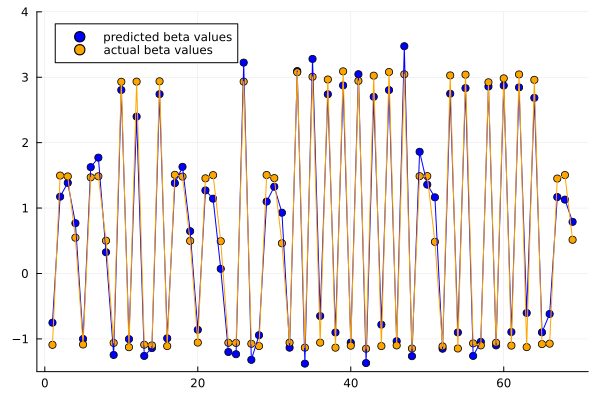

In [31]:
using Plots

x = 1:69
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
plot!(x, pred_beta_values, label = "", lc=:blue)
plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-1.5, 4)

In [15]:
model.pi_star

1000-element Vector{Vector{Float64}}:
 [0.07649392855227857, 0.8477260079315684, 0.03912231048157054, 0.03665775303458255]
 [0.07210872751991121, 0.8899389868535511, 0.013979974159542599, 0.023972311466995015]
 [0.010316251407403887, 0.017260171291161377, 0.039068986540708575, 0.9333545907607262]
 [0.933504360780092, 0.018216908284767137, 0.039495548025207786, 0.00878318290993318]
 [0.018234962076322424, 0.012812273788552594, 0.904015090904096, 0.06493767323102896]
 [0.9666727965413862, 0.013141266100378269, 0.015823495774067227, 0.004362441584168347]
 [0.9243454026564264, 0.057072723370894085, 0.012193773034522667, 0.006388100938156911]
 [0.012840530089036503, 0.056946313191441424, 0.020265930631661863, 0.9099472260878603]
 [0.00661906995200308, 0.01655680670840324, 0.016713251262527644, 0.960110872077066]
 [0.09092205179505367, 0.020714834570357315, 0.8738882768352095, 0.01447483679937934]
 [0.030516584958872675, 0.014529591245845326, 0.9126101941245437, 0.04234362967073844]
 [0.0199